In [1]:
import matplotlib.pyplot as plt
import re
import unicodedata

In [2]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD", 3: "UNK"}  # Add UNK token
        self.n_words = 4  # Start with 4 to include UNK

    def add_sentence(self, sentence):
        for word in sentence.split(" "):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1

    def build_vocab(self, max_vocab_size=1e8):
        if max_vocab_size <= self.n_words:
            raise ValueError("max_vocab_size must be greater than the number of existing tokens")

        # Sort words by frequency in descending order
        sorted_words = sorted(self.word2count, key=self.word2count.get, reverse=True)

        # Add most frequent words to vocabulary
        if max_vocab_size < len(sorted_words):
            limit  = max_vocab_size - self.n_words
        else:
            limit = len(sorted_words)
        for word in sorted_words[:limit]:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1


def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


def normalize_string(s):
    if s is not None:
        s = unicode_to_ascii(str(s).lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
        return s.strip()
    else:
        return ""

In [3]:
def read_langs():
    print("Reading lines...")

    with open("../datasets/parallel_corpus.tsv", "r", encoding="utf-8") as f:
        lines = f.readlines()

    kha_lines = []
    en_lines = []

    for line in lines[1:]:
        en_line, kha_line = line.split("\t\t\t\t\t")
        en_lines.append(en_line)
        kha_lines.append(kha_line)

    kha_lang = Lang("khasi")
    en_lang = Lang("english")

    return (
        kha_lang,
        en_lang,
        kha_lines,
        en_lines,
    )


def prepare_data():
    (kha_lang, en_lang, kha_lines, en_lines) = read_langs()

    kha_lines = [normalize_string(line) for line in kha_lines]
    en_lines = [normalize_string(line) for line in en_lines]

    print("Read %s sentence pairs" % len(kha_lines))
    print("Counting words...")
    for kha_line in kha_lines:
        kha_lang.add_sentence(normalize_string(kha_line))
    for en_line in en_lines:
        en_lang.add_sentence(normalize_string(en_line))

    kha_lang.build_vocab()
    en_lang.build_vocab()

    print("Counted words:")
    print(kha_lang.name, kha_lang.n_words)
    print(en_lang.name, en_lang.n_words)
    return (kha_lang, en_lang, kha_lines, en_lines)

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_word_frequencies(lang, title):
    frequencies = list(lang.word2count.values())

    # Histogram with log scale
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(frequencies, bins=np.logspace(0, np.log10(max(frequencies)), 50))
    plt.xscale('log')
    plt.title(f"Word Frequency Distribution - {title}")
    plt.xlabel("Frequency (Log Scale)")
    plt.ylabel("Number of Words")

    # CDF
    from statsmodels.distributions.empirical_distribution import ECDF
    plt.subplot(1, 2, 2)
    ecdf = ECDF(frequencies)
    plt.plot(ecdf.x, ecdf.y)
    plt.xscale('log')
    plt.title(f"Word Frequency Distribution (CDF) - {title}")
    plt.xlabel("Frequency (Log Scale)")
    plt.ylabel("Cumulative Probability")

    plt.tight_layout()
    plt.show()

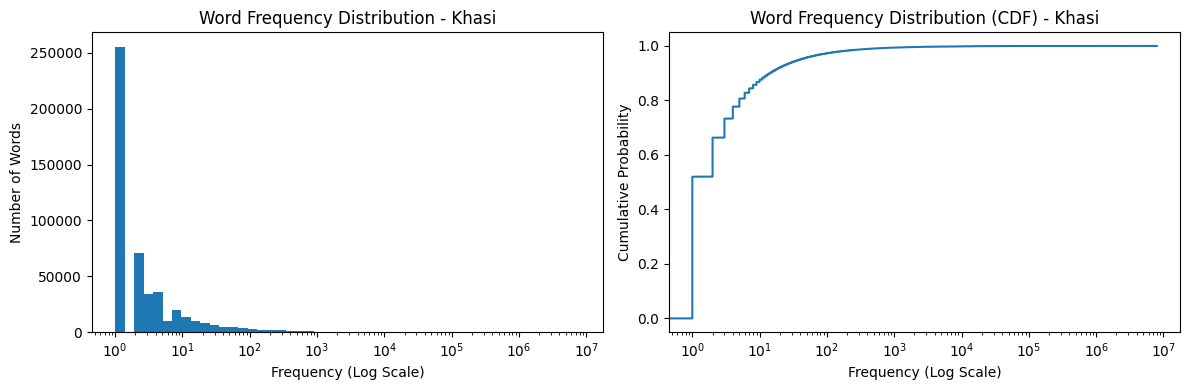

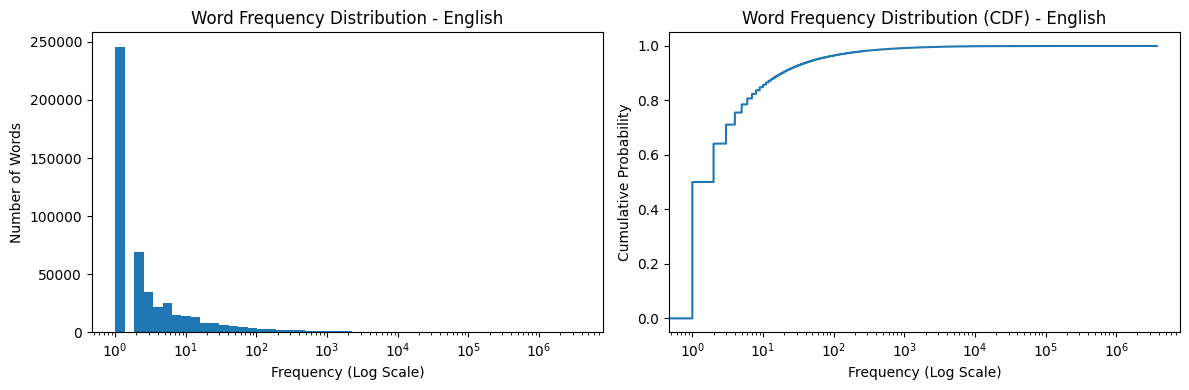

In [21]:
import pickle

if __name__ == "__main__":
    # kha_lang, en_lang, _, _ = prepare_data()

    with open("kha_lang", "rb") as fp:
        kha_lang = pickle.load(fp)
    with open("en_lang", "rb") as fp:
        en_lang = pickle.load(fp)

    plot_word_frequencies(kha_lang, "Khasi")
    plot_word_frequencies(en_lang, "English")

In [6]:
# import pickle

# with open("kha_lang", "ab") as fp:
#     pickle.dump(kha_lang, fp)

# with open("en_lang", "ab") as fp:
#     pickle.dump(en_lang, fp)